In [9]:
import pandas as pd
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import numpy as np
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
file_path = '/content/gdrive/MyDrive/Rathbun lab GDrive/Prof Rathbun/BRET efficiencies/QD BRET spectra.xlsx'
df = pd.read_excel(file_path)
df = df.melt(id_vars=['Peptide', 'Wavelength'], var_name='Trial', value_name='Luminescence')

In [11]:
# set the dtype for D5 and Wavel. to int64
df['Luminescence'] = df['Luminescence'].astype('int64')
df['Wavelength'] = df['Wavelength'].astype('int64')

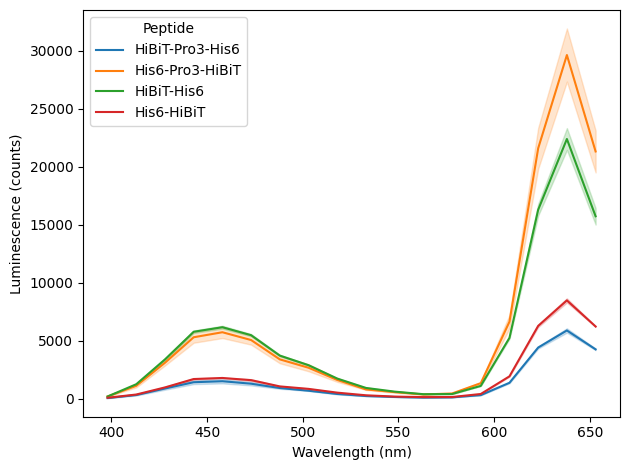

In [20]:
# rename a few columns for publication
df = df.rename(columns={'Wavelength': 'Wavelength (nm)', 'Luminescence': 'Luminescence (counts)'})
df = df.set_index('Peptide')
df = df.rename(index={
    'SmBiT-P3-His6':'HiBiT-Pro3-His6',
    'His6-Pro3-SmBiT':'His6-Pro3-HiBiT',
    'SmBiT-His6':'HiBiT-His6',
    'His6-SmBiT':'His6-HiBiT'
})
df = df.reset_index()
sns.lineplot(data=df, x='Wavelength (nm)', y='Luminescence (counts)', hue='Peptide')
plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/Rathbun lab GDrive/Prof Rathbun/BRET efficiencies/QD_linker_spectra.pdf')

In [13]:
def extrapolate(df, x_col, y_col, start=-2, stop=None):
  df[y_col] = df[y_col].astype('float64')
  df[x_col] = df[x_col].astype('float64')

  # extrapolate the final point
  y = df[y_col][start:stop].values
  x = df[x_col][start:stop].values
  print(x,y)
  m, b = np.polyfit(x, y, 1)

  # find the x intercept
  x_intercept = -b/m
  extrap_y = m*x_intercept + b

  x = np.append(df[x_col].values, x_intercept)
  y = np.append(df[y_col].values, extrap_y)

  return x, y

def trapezoidal_int(x, y, cutoff):
  all = integrate.trapezoid(y, x)
  lgbit = integrate.trapezoid(y[:cutoff], x[:cutoff])
  bret = integrate.trapezoid(y[cutoff:], x[cutoff:])
  efficiency = bret/all
  print("Total: ",all)
  print("LG-bit: ",lgbit)
  print("BRET: ",bret)
  print("Efficiency: ",efficiency)
  return all, lgbit, bret, efficiency

In [14]:
d = {
    'Peptide': [],
    'Trial': [],
    'Total': [],
    'LG-bit': [],
    'BRET': [],
    'Efficiency': [],
    'Medintz Ratio': []
}
for peptide in df['Peptide'].unique():
  for trial in df['Trial'].unique():
    print(peptide, trial)
    df_temp = df[(df['Peptide'] == peptide) & (df['Trial'] == trial)]
    x, y = extrapolate(df_temp, 'Wavelength', 'Luminescence')
    all, lgbit, bret, efficiency = trapezoidal_int(x, y, 14)
    d['Peptide'].append(peptide)
    d['Trial'].append(trial)
    d['Total'].append(all)
    d['LG-bit'].append(lgbit)
    d['BRET'].append(bret)
    d['Efficiency'].append(efficiency)
    d['Medintz Ratio'].append(bret/lgbit)

brets = pd.DataFrame(d)
brets

SmBiT-P3-His6 Trial 1
[638. 653.] [6067. 4180.]
Total:  415862.65103338665
LG-bit:  133125.0
BRET:  269762.65103338665
Efficiency:  0.6486820837674344
SmBiT-P3-His6 Trial 2
[638. 653.] [5689. 4315.]
Total:  414608.3242358087
LG-bit:  108735.0
BRET:  293933.3242358087
Efficiency:  0.7089421679547224
His6-Pro3-SmBiT Trial 1
[638. 653.] [31936. 23134.]
Total:  2081634.844921613
LG-bit:  503715.0
BRET:  1513134.844921613
Efficiency:  0.7268973463876621
His6-Pro3-SmBiT Trial 2
[638. 653.] [27354. 19514.]
Total:  1738912.0752551034
LG-bit:  420435.0
BRET:  1263824.5752551034
Efficiency:  0.7267903841944952
SmBiT-His6 Trial 1
[638. 653.] [21459. 15016.]
Total:  1507118.6966475258
LG-bit:  487927.5
BRET:  972413.6966475256
Efficiency:  0.64521374382163
SmBiT-His6 Trial 2
[638. 653.] [23340. 16445.]
Total:  1617482.5398839745
LG-bit:  509580.0
BRET:  1059662.5398839745
Efficiency:  0.655130744075906
His6-SmBiT Trial 1
[638. 653.] [8656. 6254.]
Total:  576632.3417985019
LG-bit:  150187.5
BRET:  

/tmp/ipython-input-13-1007603897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[y_col] = df[y_col].astype('float64')
/tmp/ipython-input-13-1007603897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x_col] = df[x_col].astype('float64')
/tmp/ipython-input-13-1007603897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,Peptide,Trial,Total,LG-bit,BRET,Efficiency,Medintz Ratio
0,SmBiT-P3-His6,Trial 1,4.158627e+05,133125.0,2.697627e+05,0.648682,2.026386
1,SmBiT-P3-His6,Trial 2,4.146083e+05,108735.0,2.939333e+05,0.708942,2.703208
2,His6-Pro3-SmBiT,Trial 1,2.081635e+06,503715.0,1.513135e+06,0.726897,3.003950
3,His6-Pro3-SmBiT,Trial 2,1.738912e+06,420435.0,1.263825e+06,0.726790,3.005993
4,SmBiT-His6,Trial 1,1.507119e+06,487927.5,9.724137e+05,0.645214,1.992947
5,SmBiT-His6,Trial 2,1.617483e+06,509580.0,1.059663e+06,0.655131,2.079482
6,His6-SmBiT,Trial 1,5.766323e+05,150187.5,4.091123e+05,0.709486,2.724011
7,His6-SmBiT,Trial 2,5.723468e+05,141127.5,4.138493e+05,0.723074,2.932450


In [15]:
# find the means across trials
brets_mean = brets.groupby('Peptide').mean(numeric_only=True)
brets_mean

,Total,LG-bit,BRET,Efficiency,Medintz Ratio
Peptide,,,,,
His6-Pro3-SmBiT,1.910273e+06,462075.00,1.388480e+06,0.726844,3.004972
His6-SmBiT,5.744896e+05,145657.50,4.114808e+05,0.716280,2.828230
SmBiT-His6,1.562301e+06,498753.75,1.016038e+06,0.650172,2.036215
SmBiT-P3-His6,4.152355e+05,120930.00,2.818480e+05,0.678812,2.364797


In [16]:
df[df['Wavelength']==590].groupby('Peptide').mean(numeric_only=True)

,Wavelength,Luminescence
Peptide,,
